In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Introduction to QAMpy - Pilot DSP Module

Here we demonstrate our pilot-based DSP using QPSK pilots. It's integrated in the QAMpy package and processing can be done using either blind methods or pilot-based

It is build based on the following principle:    
Signal is divided into frames of a given length.
Each frame starts with a pilot-sequnence followed by the payload
Additional pilots are inserted into the payload for continous tracking
    
Frame strutured in the following way:
    
    Pilot Sequence: N pilot symbols long. 
        Used for: 
            Frame syncronization (alignment)
            Equalization and polarization de-multiplexing
            Frequency offset estimation
            
    Phase Pilots: Periodically inserted at a ratio of P (Ex. P=32 corresponds to 1 pilot and 31 payload symbols)
        Used for:
            Phase tracking
            
    Payload: Data kept in the pilot frame
        Our pilot-dsp uses no information from the data for processing and is  fully modulation format independent. 
                    

In [2]:
from qampy import impairments, helpers, signals, equalisation,phaserec,core

## Demonstration using PM-64QAM Payload data
The signal object class contains functionality to generate a frame including both pilot symbols and payload. The pilot frame is just like any other object from the signal class and the same structure applies. 


Syntax:

    SignalWithPilots(M, frame_len, pilot_seq_len, pilot_ins_rat, nframes=1, pilot_scale=1, Mpilots=4,
                dataclass=SignalQAMGrayCoded, nmodes=1, dtype=np.complex128,  **kwargs)
    





In [10]:
mysig = signals.SignalWithPilots(64,2**16,2**10,32,nmodes=2,Mpilots=4,nframes=2,fb=24e9)

In [11]:
mysig2 = mysig.resample(mysig.fb*2,beta=0.01)
#mysig2 = mysig2[:,10000:]

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:337: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
C:\ProgramData\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:154: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [12]:
mysig3 = impairments.simulate_transmission(mysig2,snr=20,dgd=10e-12, freq_off=300e6,lwdth=100e3,roll_frame_sync=True)

In [13]:
mysig3.sync2frame(mu=1e-3)
print("FOE" + str(["%.4f"%i for i in mysig3._foe]))
mysig3.corr_foe()

FOE['0.0125', '0.0125']


C:\ProgramData\Anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:337: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
C:\ProgramData\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:154: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will res

In [14]:
eq_sig = equalisation.pilot_equalizer(mysig3,(1e-3,1e-3),45,foe_comp=False,methods=("cma","sbd"))

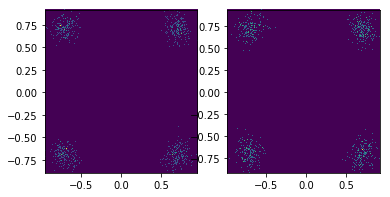

In [15]:
figure(figsize=(6,3))
subplot(121)
a = hist2d(eq_sig[1][0][:1024].real,eq_sig[1][0][:1024].imag,bins=200)

subplot(122)
a = hist2d(eq_sig[1][1][:1024].real,eq_sig[1][1][:1024].imag,bins=200)

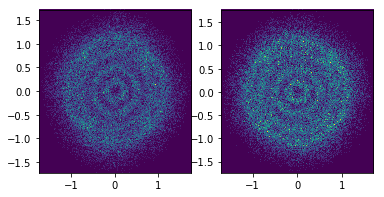

In [16]:
figure(figsize=(6,3))
subplot(121)
a = hist2d(eq_sig[1][0].flatten().real,eq_sig[1][0].flatten().imag,bins=200)

subplot(122)
a = hist2d(eq_sig[1][1].flatten().real,eq_sig[1][1].flatten().imag,bins=200)

In [17]:
cpe_sig = phaserec.pilot_cpe(eq_sig[1],N=5,use_seq=False)

2

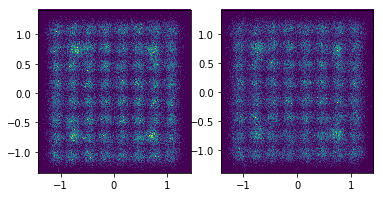

In [19]:
figure(figsize=(6,3))
subplot(121)
a = hist2d(cpe_sig[0][0].flatten().real,cpe_sig[0][0].flatten().imag,bins=200)

subplot(122)
a = hist2d(cpe_sig[0][1].flatten().real,cpe_sig[0][1].flatten().imag,bins=200)

In [20]:
ber = cpe_sig[0].cal_ber()
ser = cpe_sig[0].cal_ser()
gmi = cpe_sig[0].cal_gmi()[0]
print("BER Avg: %.2e, X-pol: %.2e Y-pol: %.2e"%(ber.mean(),ber[0],ber[1]))
print("SER Avg: %.2e, X-pol: %.2e Y-pol: %.2e"%(ser.mean(),ser[0],ser[1]))
print("GMI Avg: %.2f, X-pol: %.2f Y-pol: %.2f"%(gmi.mean(),gmi[0],gmi[1]))

BER Avg: 2.45e-02, X-pol: 2.29e-02 Y-pol: 2.62e-02
SER Avg: 1.42e-01, X-pol: 1.32e-01 Y-pol: 1.51e-01
GMI Avg: 5.45, X-pol: 5.48 Y-pol: 5.41


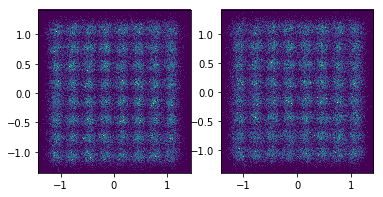

In [21]:
tmp = cpe_sig[0].get_data()
figure(figsize=(6,3))
subplot(121)
a = hist2d(tmp[0].flatten().real,tmp[0].flatten().imag,bins=200)

subplot(122)
a = hist2d(tmp[1].flatten().real,tmp[1].flatten().imag,bins=200)